# libraries

In [1]:
# Import fundamental libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json

D:\anaconda3\envs\ml_env_prod\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data prep

In [2]:
# Read CSV
df = pd.read_csv('../DATA/public_data.csv')

# Extract DATE and TOTAL (price + taxes) and save it in dictionary w
data = {'DATE': df['FECHA'].values, 'TOTAL':(df['IMPORTE_VENTA'].values + df['IMPUESTOS_VENTA'].values)}

# Create a new DataFrame from dictionary
hist = pd.DataFrame(data=data).groupby(by='DATE').sum()
# Set index to datetime64 datatype
hist.index = pd.to_datetime(hist.index,format='%Y-%m-%d')
# Resample with weeks
hist = hist.resample('W').sum()

# Create a DataFrame for Prophet (this format is required)
train_data_prophet = pd.DataFrame({
    'ds': hist.index,
    'y': hist['TOTAL'].values})

# Train model

In [3]:
# Fit the Prophet model to the entire dataset
fitted_model_PROPHET = Prophet().fit(train_data_prophet)

# Save model
with open('../OUTPUT/MODELS/sales_trained_model-0.1.0.json', 'w') as fout:
    fout.write(model_to_json(fitted_model_PROPHET))  

10:00:09 - cmdstanpy - INFO - Chain [1] start processing
10:00:09 - cmdstanpy - INFO - Chain [1] done processing


# Make predictions

In [4]:
def format_prophet(forecast,periods,freq='W-SUN',cvs_name='prediction'):
    """
    Format the Prophet forecast data and save it to a CSV file.

    Parameters:
        forecast (DataFrame): The forecast data obtained from Prophet.
        periods (int): The number of periods to include in the formatted data.
        freq (str): The frequency of the data. Default is 'W-SUN'.
        cvs_name (str): The name of the CSV file to save the formatted data. Default is 'prediction'.

    Returns:
        DataFrame: The formatted prediction data with 'FECHA' as the index.

    """
    
    # Extract the relevant columns from the forecast
    predicted_data = forecast.tail(periods)[['ds','yhat','yhat_lower','yhat_upper']]
    
    # Create a dictionary for the formatted prediction data
    dic = {
    'DATE': predicted_data['ds'],
    'PRED': predicted_data['yhat'],
    'MIN': predicted_data['yhat_lower'],
    'MAX': predicted_data['yhat_upper']}
    
    # Create a DataFrame from the dictionary with DATE as index with specified freq
    prediction_formated = pd.DataFrame(dic)
    prediction_formated.set_index('DATE',inplace=True)
    prediction_formated.index.freq = freq
    
    # Save the formatted prediction to a CSV file
    prediction_formated.to_csv('../OUTPUT/TABLES/'+cvs_name+'.csv')
    return prediction_formated

In [5]:
def make_output(pred,hist,prev_periods=208):
    """
    Plot the actual values, prediction, and uncertainty.

    Parameters:
        pred (DataFrame): The predicted values with 'PRED', 'MIN', and 'MAX' columns.
        hist (DataFrame): The historical data with 'TOTAL' column.
        prev_periods (int): The number of previous periods to plot. Default is 208.

    """
    
    # Plot the actual values
    plt.figure(figsize=(12,5),dpi=150)
    
    sns.set(style='dark')
    sns.lineplot(y=hist.tail(prev_periods)['TOTAL'],x=hist.tail(prev_periods).index,label='Historic')
    sns.lineplot(y=pred['PRED'],x=pred.index,color='red',label='Prediction')
    
    # Plot confidence interval
    plt.fill_between(pred.index,pred['MAX'],pred['MIN'],alpha=0.3,label='Uncertainty')

    plt.tight_layout()
    plt.legend()
    plt.grid()
    plt.title('Total sales and prediction (millions of MXN)')
    plt.ylabel('Total sells')
    plt.xlabel('Date')
    plt.savefig('../OUTPUT/figures/graph.png')

In [6]:
import warnings
# Warning about future deprecation of pandas function
warnings.filterwarnings("ignore", category=FutureWarning, module="prophet")

# Load model
with open('../OUTPUT/MODELS/sales_trained_model-0.1.0.json', 'r') as fin:
    fitted_model_PROPHET = model_from_json(fin.read())  # Load model

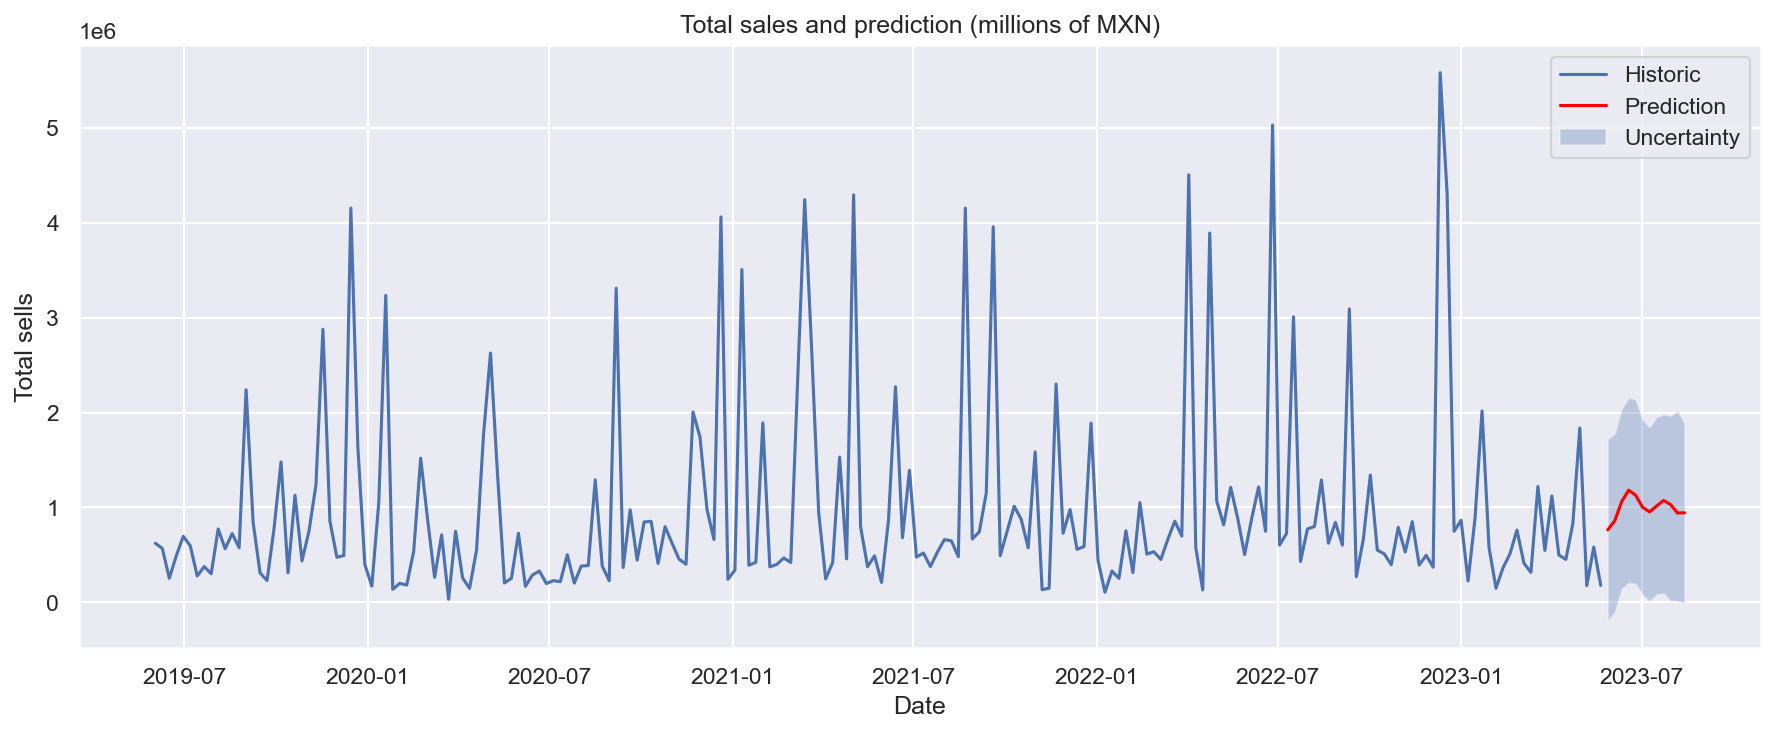

In [7]:
# Create a future dataframe for making predictions (half year)
# Dataframe include previous dates (prophet format)
future = fitted_model_PROPHET.make_future_dataframe(periods=12,freq='W-SUN')

# Use the fitted model to make predictions on the future dataframe
forecast = fitted_model_PROPHET.predict(future)

#Format the Prophet forecast data and save it to a CSV file.
predictions_ready = format_prophet(forecast,12)
# Plot the actual values, prediction, and uncertainty.
make_output(predictions_ready,hist)